In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_tot, x_l, x_r):
    
    x_train = np.linspace(x_l,x_r,N_tot)
#     x_train = np.random.uniform(low=x_l+0.000001, high=x_r, size=N_x-2)
#     x_train = np.concatenate((np.ones(1)*x_l,x_train,np.ones(1)*x_r), axis=0)
#     x_train = np.sort(x_train)
    x_train = np_to_torch(x_train)
    return x_train

def initial_temp(N_tot, T_l, T_r):
    
    T_prev = np.ones(N_tot)*T_r
    T_prev[0] = T_l
    T_prev = np_to_torch(T_prev)
    
    return T_prev

def initial_fraction(N_tot, s_initial, x_train):
    
    x_train = x_train.detach().numpy()
    f_prev = np.zeros(N_tot)
    for i in range(N_tot):
        if x_train[i]<=s_initial:
            f_prev[i] = 1
    f_prev = np_to_torch(f_prev)
    
    return f_prev
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model-1
        modules_1 = []
        for i in range(len(layer_size) - 1):
            modules_1.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i!=len(layer_size) - 2:
                modules_1.append(nn.Tanh())
                
        self.fc_1 = nn.Sequential(*modules_1)
        self.fc_1.apply(xavier_init)
        
        # Fully conected model-2
        modules_2 = []
        for i in range(len(layer_size) - 1):
            modules_2.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i != len(layer_size) - 2 :
                modules_2.append(nn.Tanh())
                
        self.fc_2 = nn.Sequential(*modules_2)
        self.fc_2.apply(xavier_init)
        
    def forward(self, x_train):
        
        T = self.fc_1( x_train )
        dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        
        f = self.fc_2( x_train )
        dfdx = torch.autograd.grad(f, x_train, grad_outputs=torch.ones_like(f), create_graph=True)[0]
        df2dx2 = torch.autograd.grad(dfdx, x_train, grad_outputs=torch.ones_like(dfdx), create_graph=True)[0]
        
        return T, dTdx, d2Tdx2, f
    
def get_loss(x_train, k1, k2, T_l, T_r, x_l, x_r, t_i, w1, w2, w3, w4, w5, T_prev, f_prev, f_lim, N_x, mat_1, mat_2, N_1, N_2):

    T, dTdx, d2Tdx2, f = model(x_train)

    mat_1 = torch.where(f >= f_lim,1,0)
    N_1 = torch.sum( mat_1 )
    mat_2 = torch.where(f < f_lim,1,0)
    N_2 = torch.sum( mat_2 )
    
    eq1 = w1*torch.sum( torch.square( torch.mul(mat_1, T - T_prev - del_t*k1*d2Tdx2) ) )/(N_1)
    eq2 = w2*torch.sum( torch.square( torch.mul(mat_2, f - f_prev - del_t*k2*d2Tdx2 ) ) )/(N_2)
    bc1 = w3*torch.sum( torch.square( torch.mul(torch.where(x_train == 0,1,0), T - T_l ) ) )
    bc2 = w4*torch.sum( torch.square( torch.mul(mat_2, T - T_r  ) ) )/(N_2)  
    bc3 = w5*torch.sum( torch.square( torch.mul(mat_2, dTdx  ) ) )/(N_2) 
    
    if (N_1 == 0):
        eq1 = 0
    if (N_2 == 0):
        eq2 = 0
        bc3 = 0

    loss = eq1 + eq2 + bc1 + bc2 
    
    return loss, eq1, eq2, bc1, bc2, bc3

def print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3):
    print('epoch = ',epoch)
    print('loss = ',loss)
    print('eq1_loss = ',eq1)
    print('eq2_loss = ',eq2)
    print('bc1_loss = ',bc1)
    print('bc2_loss = ',bc2)
#     print('bc3_loss = ',bc3)
    
def lambda_analytical(k1, k2):
    x = []
    er = []
    cnt = 0
    for i in np.arange(0.1, 5, 0.001):
        x.append(i)
        er.append(math.erf(x[-1]))
        cnt = cnt+1

    x = np.array(x)
    er = np.array(er)
    y =[]
    y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/(k2)

    for i in range(1,cnt):
        if(y[i]*y[i-1]<0):
            lam = x[i]
            break
    
    return lam

def analytical(N_x_test, x_test, t_test, T_r, k1, k2, T_l):

    x_test = x_test.detach().numpy()
    y_an = np.zeros((N_x_test, 1))
    lam = lambda_analytical(k1, k2)
    s = np.sqrt(k1*t_test)*2*lam
    
    for j in range(N_x_test):
        if(x_test[j]<s):
            y_an[j] = T_l - T_l*math.erf( x_test[j]/( 2*np.sqrt(k1*t_test) ) )/ math.erf(lam) 
        else:
            y_an[j] = T_r
            
    y_an = np.reshape(y_an, (N_x_test, 1))
    
    return y_an, s
    
def temperature_fraction_correction(f_new, f_prev, T_new, N_x, T_r):
    
    for i in range(N_x):
        if f_new[i][0]>=1 or f_prev[i][0]>=1:
            f_new[i][0] = 1
            continue
            
        if f_new[i][0]<0:
            f_new[i][0] = 0
            
#         if f_new[i][0]<1 :
#             T_new[i][0] = T_r
    
    f_new = torch.FloatTensor(f_new)  
    T_new = torch.FloatTensor(T_new)   
    return T_new, f_new
    


In [3]:
N_x = 400
N_t = 40

x_l = 0
x_r = 0.15

T_r = 0
T_l = 1

t_i = 0
t_f = 0.2

accuracy_cap = 0.0004
del_t = 0.001
s_initial = 0.01
f_lim = 1

# Neural network params
layer_size = [1, 3, 3, 1]

# material params
k1 = 0.05
k2 = 0.8

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 3e-4
epochs = 50001
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

ANN(
  (fc_1): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Softsign()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Softsign()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
  (fc_2): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 44


In [4]:
loss_store = []
T_store_an = []
T_store_pred = []
f_store_pred = []
t_store = []
s_store_an = []
model.train()  

# Initial conditions
x_train = x_train_data(N_x, x_l, x_r)
T_prev = initial_temp(N_x, t_i, t_f)
f_prev = initial_fraction(N_x, s_initial, x_train)
t_test = 0
T_store_pred.append(T_prev)
f_store_pred.append(f_prev)

# Loss function weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1

for i in range(N_t):

    t_test = t_test + del_t
    t_store.append(t_test)
    print("t = ", t_test)
    print(" ")

    mat_1 = torch.where(f_prev >= f_lim,1,0)
    N_1 = torch.sum( mat_1 )
    mat_2 = torch.where(f_prev < f_lim,1,0)
    N_2 = torch.sum( mat_2 )
    
    if(i>1):
        epochs = 2001

    for epoch in range(epochs):        
        #Backpropogation and optimisation
        loss, eq1, eq2, bc1, bc2, bc3 = get_loss(x_train, k1, k2, T_l, T_r, x_l, x_r, t_i, 
                                            w1, w2, w3, w4, w5, T_prev, f_prev, f_lim, N_x, mat_1, mat_2, N_1, N_2)
        
        optimiser1.zero_grad()
        loss.backward()
        optimiser1.step()  
        loss_store.append(loss.detach().numpy())

        if epoch%2000==0:
            print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3)
            print("")

#             if loss.detach().numpy()<8e-5:
#                 break

    # Store the results after each time step
    T_prev, dTdx, d2Tdx2, f_prev = model(x_train)
    T_an, s_an = analytical(N_x, x_train, t_test, T_r, k1, k2, T_l)

    T_prev, f_prev = temperature_fraction_correction(f_prev.detach().numpy(), f_store_pred[-1], T_prev.detach().numpy(), N_x, T_r)

    T_store_pred.append(T_prev.detach().numpy())
    T_store_an.append(T_an)
    s_store_an.append(s_an)
    f_store_pred.append(f_prev.detach().numpy())

    T_prev = torch.FloatTensor(T_store_pred[-1]).clone().detach().requires_grad_(False)
    f_prev = torch.FloatTensor(f_store_pred[-1]).clone().detach().requires_grad_(False)


t =  0.001
 
epoch =  0
loss =  tensor(0.9611, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0648, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.8951, grad_fn=<MulBackward0>)
bc2_loss =  tensor(0.0011, grad_fn=<DivBackward0>)

epoch =  2000
loss =  tensor(0.2539, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0497, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.0627, grad_fn=<MulBackward0>)
bc2_loss =  tensor(0.1415, grad_fn=<DivBackward0>)

epoch =  4000
loss =  tensor(0.2146, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0462, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.0281, grad_fn=<MulBackward0>)
bc2_loss =  tensor(0.1402, grad_fn=<DivBackward0>)

epoch =  6000
loss =  tensor(0.1903, grad_fn=<AddBackward0>)
eq1_loss =  0
eq2_loss =  tensor(0.0413, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.0210, grad_fn=<MulBackward0>)
bc2_loss =  tensor(0.1279, grad_fn=<DivBackward0>)

epoch =  8000
loss =  tensor(0.1397, grad_fn=<AddBackward0>)
eq1_loss =  0

KeyboardInterrupt: 

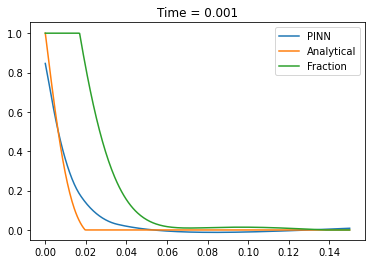

In [8]:
i = 0
j = N_x
k = 0
plt.plot(x_train[i:j].detach().numpy(), T_store_pred[k+1][i:j])
plt.plot(x_train[i:j].detach().numpy(), T_store_an[k][i:j])
plt.plot(x_train[i:j].detach().numpy(), f_store_pred[k+1][i:j])
Title = "Time = " + str( "{:.3f}".format (t_store[k]))
plt.title(Title)
plt.legend(["PINN", "Analytical", "Fraction"])
plt.ylim(-0.05, 1.055)
plt.show()

In [ ]:
T_store_pred[1][i:j]

In [ ]:
Title = "Time = " + str( "{:.3f}".format (t_store[k]))
plt.plot(x_test_np[i:j], f_store_pred[k][i:j])
plt.title(Title)
plt.xlabel("")